> ### **BIODATA**
>
> - **Full Name** : Venansius Ryan Tjahjono
>
> - **Email Address** : venansiusrt@gmail.com

> ### **Importing the libraries**
>
> In this part, I have imported several useful libraries to support image classification task on paper-rock-scissor dataset. The detail concerning the function of each library are written on the code below.

In [1]:
import tensorflow as tf # employ CNN model
import matplotlib.pyplot as plt # visualization
import os # read file
import zipfile # read compressed file
import numpy as np # mathematics calculation
import time # measure running time
from tqdm import tqdm # add progressbar
from keras.preprocessing import image # Set of tools for image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator # images augmentation library
from tensorflow.keras.callbacks import ModelCheckpoint # add checkpoint to save the model's weight
from tensorflow.keras.callbacks import ReduceLROnPlateau # create adaptive learning schemes 
from tensorflow.keras.callbacks import EarlyStopping # set up an early stopping mechanism
from google.colab import files # upload any file to google colab

> ### **Preparation**
> In this part, I do the preparation to unzip and locate the dataset. AFter that, I set the image size into 128 x 128.


In [2]:
# Importing the dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

address_local_zipfile = '/tmp/rockpaperscissors.zip'
zip_read = zipfile.ZipFile(address_local_zipfile,'r')
zip_read.extractall('/tmp')
zip_read.close()

--2020-10-24 15:53:34--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  7.90MB/s    in 60s     

2020-10-24 15:54:34 (5.17 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [4]:
# Locating our dataset
dataset_directory = "/tmp/rockpaperscissors/rps-cv-images/"
os.listdir(dataset_directory)

['rock', 'paper', 'scissors', 'README_rpc-cv-images.txt']

In [5]:
# Setting size of image into (image_size, image_size)
image_size = 128

> ### **Set up for images augmentation**

In [6]:
# Creating image data generator
converter = ImageDataGenerator(rescale = 1./255, 
                               shear_range = 0.125, 
                               zoom_range = 0.125,
                               rotation_range = 90,
                               horizontal_flip = True, 
                               vertical_flip = True,
                               validation_split = 0.4)

# Augmenting the dataset
data_train = converter.flow_from_directory(dataset_directory, 
                                           target_size = (image_size,image_size), 
                                           batch_size = 64, 
                                           class_mode ='categorical', 
                                           subset = 'training')
data_val = converter.flow_from_directory(dataset_directory, 
                                         target_size = (image_size,image_size), 
                                         batch_size = 64,
                                         class_mode = 'categorical', 
                                         subset = 'validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


> ### **Design Convolutional Neural Net with its optimizer**

In [7]:
# Designing the layers
CNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (4,4), activation = 'selu', input_shape= (image_size,image_size,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation=  'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'selu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (2,2), activation = 'selu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

# Defining Optimizer
the_optimizer = tf.keras.optimizers.Adam(amsgrad = True)

# Compiling the layers and optimizer
CNN_model.compile(optimizer = the_optimizer, 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)       3

> ### **Create callbacks that are checkpoint, adaptive learning, and early stopping**

In [8]:
filepath = "/tmp/rockpaperscissors/improvement_at_epoch_{epoch:02d}_with_acc_of_{accuracy:.2f}.hdf5"

# Creating checkpoint to save the model
checkpoint = ModelCheckpoint(filepath,
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = "accuracy",
                             mode = "max",
                             verbose = 1)

# Setting adaptive learning scheme
adaptive_learning = ReduceLROnPlateau(factor = 0.99999, 
                                      patience = 2, 
                                      min_lr = 0.00001, 
                                      verbose = 1)

# Setting early stopping mechanism
earlystop = EarlyStopping(monitor = "accuracy",
                          patience = 10,
                          verbose = True,
                          mode="max")

> ### **Training session**

In [9]:
stopwatch_start = time.time()

# Training the neural network
trained_model = CNN_model.fit(data_train, 
                              epochs = 30,
                              verbose = True, 
                              validation_data = data_val,
                              callbacks = [checkpoint, adaptive_learning, earlystop])

# Calculating training time
stopwatch_stop = time.time()
minute = int(np.floor((stopwatch_stop-stopwatch_start)/60));
sec = int(np.ceil((stopwatch_stop-stopwatch_start)-minute*60));
print('\nTraining time:', minute, 'minutes', sec, 'seconds')

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.0316 - accuracy: 0.4688
Epoch 00001: accuracy improved from -inf to 0.46880, saving model to /tmp/rockpaperscissors/improvement_at_epoch_01_with_acc_of_0.47.hdf5
21/21 [==============================] - 12s 568ms/step - loss: 1.0316 - accuracy: 0.4688 - val_loss: 0.7905 - val_accuracy: 0.6190
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.7374
Epoch 00002: accuracy improved from 0.46880 to 0.73744, saving model to /tmp/rockpaperscissors/improvement_at_epoch_02_with_acc_of_0.74.hdf5
21/21 [==============================] - 12s 558ms/step - loss: 0.6365 - accuracy: 0.7374 - val_loss: 0.6512 - val_accuracy: 0.7368
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.7869
Epoch 00003: accuracy improved from 0.73744 to 0.78691, saving model to /tmp/rockpaperscissors/improvement_at_epoch_03_with_acc_of_0.79.hdf5
21/21 [===========================

> ### **Training visualization and its report**

---------------------------------------------------
|                 TRAINING REPORT                 |
---------------------------------------------------
| Training accuracy in the last epoch	: 98.4 % |
| Validation accuracy in the last epoch	: 97.37 % |
---------------------------------------------------
| Training loss in the last epoch	: 0.04455 |
| Validation loss in the last epoch	: 0.07272 |
---------------------------------------------------


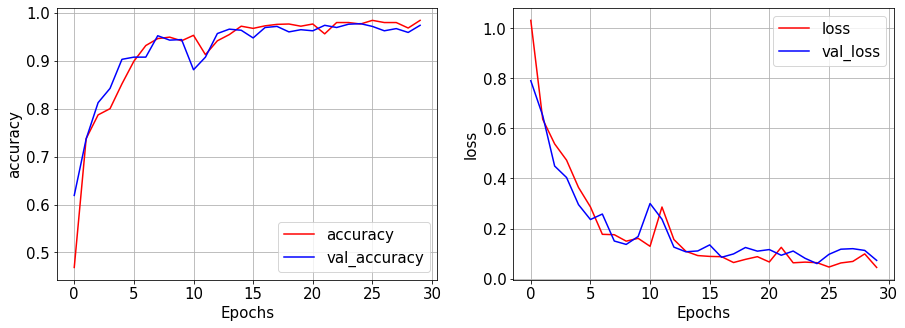

In [10]:
# Visualizing the training result

def training_visualizer(fig, num, sizefont, string, model):
    ax = fig.add_subplot(num)
    ax.grid(True)
    plt.plot(model.history[string],'r') 
    plt.plot(model.history['val_' + string], 'b')
    plt.xlabel("Epochs", fontsize = sizefont)
    plt.ylabel(string, fontsize = sizefont)
    plt.legend([string, 'val_' + string], fontsize = sizefont)
    ax.tick_params(axis="x", labelsize = sizefont)
    ax.tick_params(axis="y", labelsize = sizefont)

fig = plt.figure(figsize=(15,5))
fs = 15
training_visualizer(fig, 121, fs, "accuracy", trained_model)
training_visualizer(fig, 122, fs, "loss", trained_model)

print('---------------------------------------------------')
print('|                 TRAINING REPORT                 |')
print('---------------------------------------------------')
print('| Training accuracy in the last epoch\t:', np.round(trained_model.history['accuracy'][-1]*100, 2), "% |")
print('| Validation accuracy in the last epoch\t:', np.round(trained_model.history['val_accuracy'][-1]*100, 2), "% |")
print('---------------------------------------------------')
print('| Training loss in the last epoch\t:', np.round(trained_model.history['loss'][-1], 5), '|')
print('| Validation loss in the last epoch\t:', np.round(trained_model.history['val_loss'][-1], 5), '|')
print('---------------------------------------------------')

> ### **Hands on! Prediction time**

Saving bn7yju6XvU87slzH.png to bn7yju6XvU87slzH.png
bn7yju6XvU87slzH.png


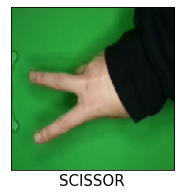

In [12]:
uploaded_image = files.upload()

for file_name in uploaded_image.keys():
    IMG_FILE = image.load_img(file_name, target_size = (image_size,image_size))
    
    fig = plt.figure(figsize = (3,3))
    x = image.img_to_array(IMG_FILE)
    x = np.expand_dims(x, axis = 0)

    images = np.vstack([x])/255
    classes = CNN_model.predict(images)

    print(file_name)
    if np.argmax(classes[0]) == 0:
        label = "PAPER"
    elif np.argmax(classes[0]) == 1:
        label = "ROCK"
    else:
        label = "SCISSOR"

    plt.imshow(IMG_FILE)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label, fontsize = 15)